In [63]:
import inspect
import numpy as np
import matplotlib.pyplot as plt
# from andi_datasets.models_phenom import models_phenom
# import stochastic
# from andi_datasets.utils_trajectories import plot_trajs
from tsai.all import *
import sklearn.metrics as skm

from tqdm import tqdm
np.random.seed(7)


In [64]:
with open('trajs.csv', 'rb') as f:
    trajs = np.load(f)
    
with open('labels.csv', 'rb') as f:
    labels = np.load(f)
    
with open('trajs_test.csv', 'rb') as f:
    trajs_test = np.load(f)
    
with open('labels_test.csv', 'rb') as f:
    labels_test = np.load(f)

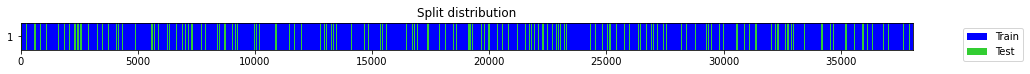

((#30480) [19495,1973,20829,1185,29221,7097,31310,35703,26019,25284...],
 (#7620) [29344,35578,26320,11446,6745,12806,24861,14341,25048,9357...])

In [65]:
splits = get_splits(labels, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits

In [66]:
# archs = [
#     "GRU",
#     "MLP",
#     "FCN",
#     "ResNet",
#     "mWDN",
#     "TCN",
#     "InceptionTime",
#     "XceptionTime",
#     "ResCNN",
#     "TST",
#     "TSiT",
#     "MiniRocket",
#     "XCM",
#     "gMLP",
#     "TSSequencerPlus",
#     "TransformerModel",
#     "LSTMAttention",
#     "GRUAttention",
#     "RNN_FCN",
#     "MLSTM_FCN",
#     "MRNN_FCN",
#     "GRU_FCN",
#     "LSTM_FCN",
#     "TSTPlus"]

In [67]:
archs = [
    "MLSTM_FCN"]

In [68]:
labels_alpha = labels[:,0]
labels_test_alpha = labels_test[:,0]

labels_D = labels[:,1]
labels_test_D = labels_test[:,1]

# Alpha

In [69]:
tfms = [None, TSRegression()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(trajs, labels_alpha, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)


  0%|          | 0/1 [00:00<?, ?it/s]

MLSTM_FCN


epoch,train_loss,valid_loss,_rmse,time
0,0.009872,0.003976,0.063058,00:02
1,0.006116,0.004373,0.066131,00:02
2,0.004582,0.003028,0.055024,00:02
3,0.003660,0.002955,0.054356,00:02
4,0.003196,0.002730,0.052251,00:02
5,0.002804,0.002457,0.049566,00:02
6,0.002609,0.003088,0.055567,00:02
7,0.002577,0.002700,0.051965,00:02
8,0.002481,0.004565,0.067567,00:02
9,0.002446,0.002655,0.051527,00:02


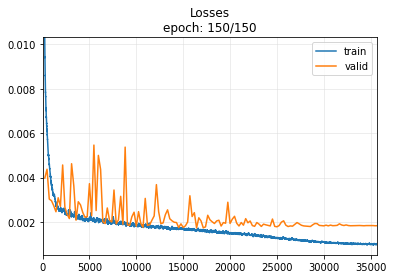

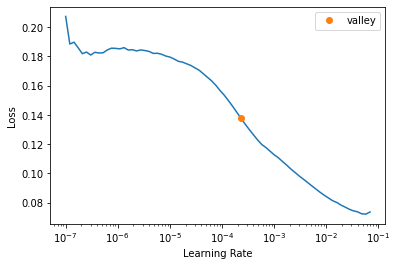

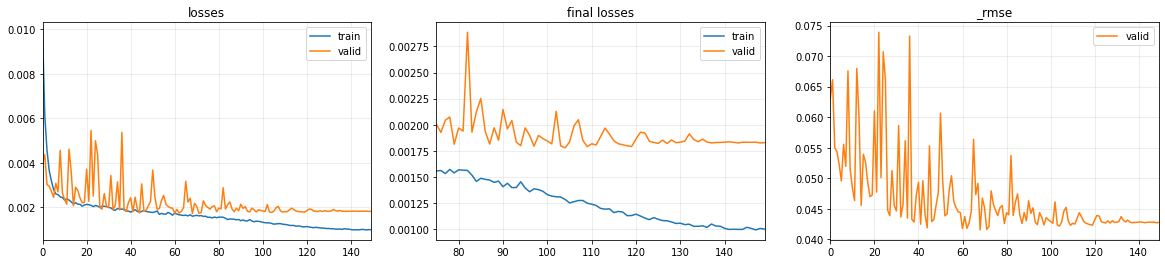

100%|██████████| 1/1 [10:33<00:00, 633.21s/it]


In [70]:
for arch in tqdm(archs):
    
    learn = ts_learner(dls, arch, metrics=rmse, cbs=ShowGraph())
    learn.lr_find()
    print(arch)
    learn.fit_one_cycle(150, learn.lr)
    learn.save_all(path='export', dls_fname='dls', model_fname=arch+'_Alpha', learner_fname=arch+'_Alpha')


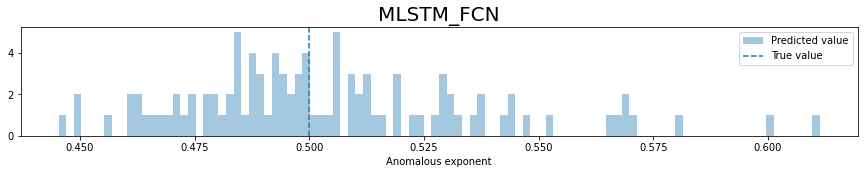

In [71]:
# fig, axes = plt.subplots(len(archs), 1, figsize=(15, 10))

for arch  in archs:
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))

    learn = load_learner_all(path='export', dls_fname='dls', model_fname=arch+'_Alpha', learner_fname=arch+'_Alpha')

    probas, _, preds = learn.get_X_preds(trajs_test)
    preds = np.array(preds)[:,0]

    for idx, u in enumerate(np.unique(labels_test_alpha)):

        mask = labels_test_alpha == u
        ax.hist(
            preds[mask],
            facecolor=f"C{idx}",
            bins=100,
            alpha=0.4,
            label="Predicted value" if idx == 0 else "",
        )
        ax.axvline(u, ls="--", c=f"C{idx}", label="True value" if idx == 0 else "")
    ax.legend()
    ax.set_xlabel("Anomalous exponent", fontsize=10)
    ax.set_title('{}'.format(arch), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
#     ax.set_xlim([np.min(labels_alpha), np.max(labels_alpha)])

# D


In [72]:

tfms = [None, TSRegression()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(trajs, labels_D, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)


  0%|          | 0/1 [00:00<?, ?it/s]

MLSTM_FCN


epoch,train_loss,valid_loss,_rmse,time
0,10.767004,8.258271,2.873721,00:02
1,3.687975,2.559004,1.599689,00:02
2,1.194502,0.598875,0.773870,00:02
3,0.828331,0.422878,0.650291,00:02
4,0.693192,0.392487,0.626488,00:02
5,0.572348,0.376065,0.613241,00:02
6,0.499496,0.403863,0.635502,00:02
7,0.446306,0.379664,0.616169,00:02
8,0.412281,0.392736,0.626686,00:02
9,0.395589,0.373902,0.611476,00:02


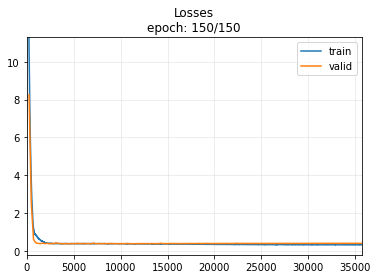

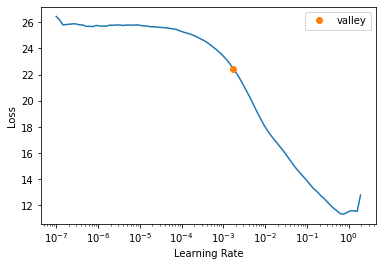

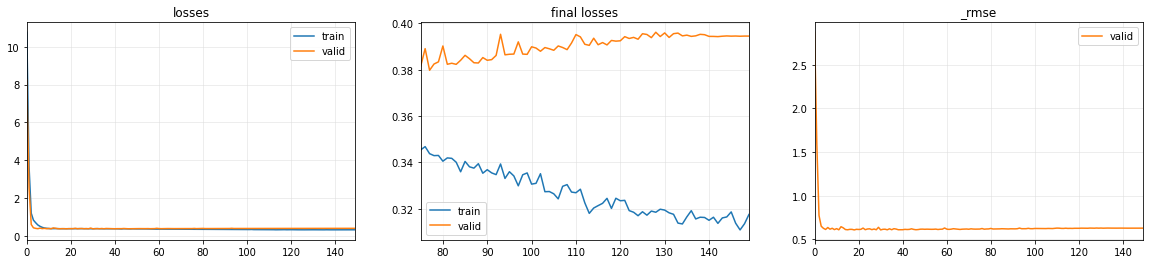

100%|██████████| 1/1 [10:34<00:00, 634.60s/it]


In [73]:

for arch in tqdm(archs):
    
    learn = ts_learner(dls, arch, metrics=rmse, cbs=ShowGraph())
    learn.lr_find()
    print(arch)
    learn.fit_one_cycle(150, learn.lr)
    learn.save_all(path='export', dls_fname='dls', model_fname=arch+'_D', learner_fname=arch+'_D')



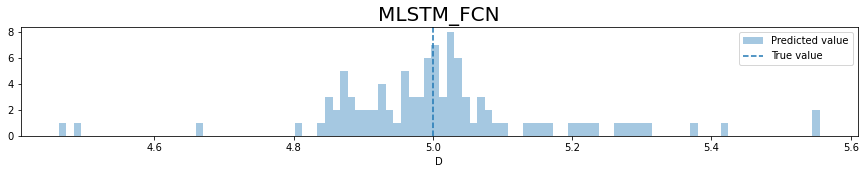

In [74]:

for arch  in archs:
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))

    learn = load_learner_all(path='export', dls_fname='dls', model_fname=arch+'_D', learner_fname=arch+'_D')

    probas, _, preds = learn.get_X_preds(trajs_test)
    preds = np.array(preds)[:,0]

    for idx, u in enumerate(np.unique(labels_test_D)):

        mask = labels_test_D == u
        ax.hist(
            preds[mask],
            facecolor=f"C{idx}",
            bins=100,
            alpha=0.4,
            label="Predicted value" if idx == 0 else "",
        )
        ax.axvline(u, ls="--", c=f"C{idx}", label="True value" if idx == 0 else "")
    ax.legend()
    ax.set_xlabel("D", fontsize=10)
    ax.set_title('{}'.format(arch), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
#     ax.set_xlim([np.min(labels_D), np.max(labels_D)])